In [1]:
import os
drive_dir = '/work3/s184399/msc'
data_dir = os.path.join(drive_dir, 'data')
cache_dir = os.path.join(drive_dir, "cache_dir", "huggingface")

In [2]:
#!pip install spacy
#!python -m spacy download en_core_web_trf

from typing import Union, List, Dict, TypeVar, Tuple

import spacy   # Doc: https://spacy.io/api/
from spacy.matcher import DependencyMatcher


pattern_t = TypeVar("pattern_t", bound=List[Dict[str, Union[str, Dict]]])


class SymbolicStatement(object):
    def __init__(self, subject_: str, property_: str, object_: str, polarity: bool):
        self.subject = subject_
        self.property = property_
        self.object = object_
        self.polarity = polarity   # Whether the statement should be considered true or false.

    def __eq__(self, other):
        return self.subject == other.subject and self.property == other.property and self.object == other.object and self.polarity == other.polarity

    def __hash__(self):
      return hash((self.subject, self.property, self.object, self.polarity))

    def eq_different_polarity(self, other):
        return self.subject == other.subject and self.property == other.property and self.object == other.object


class AgreementChecker(object):
  AGREE, DISAGREE, AMBIGUOUS = 1, 0, -1

  def __init__(self, patterns: List[Tuple[str, pattern_t]]):
    self.nlp = spacy.load("en_core_web_trf")
    self.nlp.add_pipe("merge_entities")
    self.matcher = DependencyMatcher(self.nlp.vocab)
    for pattern_name, pattern in patterns:
      # Rename pattern by postfixing a number.
      i = 0
      while f"{pattern_name}_{i}" in self.matcher:
          i+=1    # Find the next available name, because book-keeping doesn't make sense at this small scale.
      self.matcher.add(f"{pattern_name}_{i}", [pattern])    # Also needs to store a key for subject, property, object, polarity

  def extract_claims(self, response:str) -> List[SymbolicStatement]:
    doc = self.nlp(response)
    matches = self.matcher(doc)
    claims = []
    for match_id, token_idxs in matches:
      subject, property_, object_, polarity = None, None, None, True
      property_idx = -1
      pattern = self.matcher.get(match_id)
      for token_pattern, token_idx in zip(pattern[1][0], token_idxs):
        match token_pattern["RIGHT_ID"]:
          case "property":
            property_ = doc[token_idx].lemma_
            property_idx = token_idx
          case "subject":
            subject = doc[token_idx].lemma_
          case "object":
            object_ = doc[token_idx].lemma_
      polarity = len(list(filter(lambda x: x.dep_ == 'neg', doc[property_idx].children))) == 0
      claims.append(SymbolicStatement(subject, property_, object_, polarity))
    return claims

  def classify_agreement(self, correct_subject:str, correct_property: str, correct_object:str, response: str) -> int:
    if response.startswith("Did"):   # Sometimes the model simply repeats the question...
      return self.AMBIGUOUS
    claims = self.extract_claims(response)
    predicate = lambda x: (x.subject == correct_subject) and (x.object == correct_object) and (x.property == correct_property)
    relevant_claims = set(filter(predicate, claims))

    # Polarity from claim
    if len(relevant_claims) == 1:
      polarity = int(next(iter(relevant_claims)).polarity)
    else:
      polarity = self.AMBIGUOUS

    # See if the response starts with something contradicting the claim
    if response.startswith("No"):
      return self.AMBIGUOUS if polarity == 1 else self.DISAGREE
    elif response.startswith("Yes"):
      return self.AMBIGUOUS if polarity == 0 else self.AGREE
    return polarity


pattern_attend = [
  {
    "RIGHT_ID": "property",
    "RIGHT_ATTRS": {"LEMMA": "attend"}
  },
  {
    "LEFT_ID": "property",
    "REL_OP": ">",                      # `>` means immediately head of. Semgrex operators: https://spacy.io/usage/rule-based-matching#dependencymatcher-operators
    "RIGHT_ID": "subject",
    "RIGHT_ATTRS": {"DEP": "nsubj", "ENT_TYPE": "PERSON"}     # POS, TAG, MORPH, DEP, LEMMA, SHAPE, ENT_TYPE and more are possible: https://spacy.io/usage/rule-based-matching#adding-patterns-attributes
  },
  {
    "LEFT_ID": "property",
    "REL_OP": ">",
    "RIGHT_ID": "object",
    "RIGHT_ATTRS": {"DEP": "dobj", "ENT_TYPE": "ORG"}
  }
]
agreement_checker = AgreementChecker([("ATTEND", pattern_attend)])
test_args = {
  "correct_subject": "Mette Frederiksen",
  "correct_property": "attend",
  "correct_object": "Aarhus University",
  "response": "No, Mette Frederiksen attended Aalborg University, she did not attend Aarhus University",
}
assert agreement_checker.classify_agreement(**test_args) == 0

In [3]:
from typing import List
import transformers
from tqdm.notebook import tqdm
import numpy as np
import torch

dtype = np.float16


class Hook:
  # Inspired by https://github.com/saprmarks/geometry-of-truth/blob/main/generate_acts.py
  def __init__(self):
    self.activations = []
    self.idx = -1   # The index of the token we look at the internal state for

  def __call__(self, module, args, output, **kwargs):
    assert len(output) == 2 and isinstance(output[1], transformers.cache_utils.DynamicCache) and isinstance(output[0], torch.Tensor)
    o = output[0][...,self.idx,:].detach().cpu().numpy().astype(dtype)
    self.activations.append(o)


def compute_activations(statements: List[str], model: torch.nn.Module) -> np.ndarray:
  """
    Returns:
    - Activations of shape [num_layers, num_samples, n_hidden_dim]
  """
  # Empty forward hooks just in case something happened.
  for layer in model.model.layers:
    layer._forward_hooks.clear()
    assert not len(layer._forward_hooks)

  hooks = []
  handles = []
  for i, layer in enumerate(model.model.layers):
    hook = Hook()
    handle = layer.register_forward_hook(hook)
    hooks.append(hook)
    handles.append(handle)

  for statement in tqdm(statements):
    tokens = tokenizer.encode(statement, return_tensors='pt').cuda()
    _ = model(tokens)

  for handle in handles:
    handle.remove()

  activations = []
  for hook in hooks:
    activations.append(np.vstack(hook.activations))

  return np.stack(activations, axis=0)


def make_llm_predictions_with_probs(df, model):
  questions = df["Questions"].tolist()
  statements = df["Statements"].tolist()
  labels = df["isTrue"].to_numpy()

  probabilities = []
  for i in tqdm(range(len(questions))):
    text = tokenizer.apply_chat_template([{"role": "user", "content": questions[i]}], tokenize=False, add_generation_prompt=True) + "\n"
    tokens = tokenizer(text, return_tensors="pt", add_special_tokens=True)
    tokens = {k:v.cuda() for k,v in tokens.items()}
    out = model(**tokens)
    probs = torch.nn.functional.softmax(out['logits'][0,-1,:],dim=0).cpu().detach().numpy()
    probabilities.append(probs)
  probabilities = np.array(probabilities)  # Has same order as in `activations`.
  assert np.all(np.isclose(np.sum(probabilities, axis=1), 1.0))
  yes_no_probs = probabilities[:,[tokenizer.vocab["No"], tokenizer.vocab["Yes"]]]
  pred = np.argmax(yes_no_probs, axis=1)
  df["Pred_from_probs"] = pred
  return df


### TODO: Make this line general: s, p, o = row['nameLabel'], "attend", row["educationLabel"]
def make_llm_predictions_with_generation(df, model):
  questions = df["Questions"].tolist()
  statements = df["Statements"].tolist()
  labels = df["isTrue"].to_numpy()
  responses = []
  for i in tqdm(range(len(questions))):
    text = tokenizer.apply_chat_template([{"role": "user", "content": questions[i]}], tokenize=False, add_generation_prompt=True) + "\n"
    #text = "Question: "+questions[i]+"\nAnswer: "
    tokens = tokenizer(text, return_tensors="pt", add_special_tokens=True)
    tokens = {k:v.cuda() for k,v in tokens.items()}
    out = model.generate(**tokens, max_new_tokens=32)
    out = tokenizer.decode(out[0], skip_special_tokens=True, clean_up_tokenization_spaces=False)
    out = out.replace(text, '')
    responses.append(out)
  preds = []
  for i, (_, row) in enumerate(df.iterrows()):
    s, p, o = row['nameLabel'], "attend", row["educationLabel"]
    pred = agreement_checker.classify_agreement(
      correct_subject=s,
      correct_property=p,
      correct_object=o,
      response=responses[i],
    )
    preds.append(pred)
  df["Responses"] = np.array(responses)
  df["Pred_from_gens"] = np.array(preds)
  return df

In [4]:
import pandas as pd
df = pd.read_csv(os.path.join(data_dir, 'politicians_edge_substitutions.csv'))
idx = 50
df_concat = pd.concat((df.loc[df['isTrue'] == 0][0:idx], df.loc[df['isTrue'] == 1][0:idx]))

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


activations = None

def plot_labeled_pca(layer, n_components, df_concat, pred_col, activations):
    X, y, y_hat = activations[layer,...], df_concat['isTrue'], df_concat[pred_col]
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    fig, ax = plt.subplots(n_components, n_components, figsize=(20,20))
    for x_component in range(n_components):
      for y_component in range(n_components):
        ax[x_component, y_component].scatter(X_pca[(y==0) & (y_hat == 0), x_component], X_pca[(y==0) & (y_hat == 0), y_component], label="False, predicted false", color='tab:blue', marker='x')
        ax[x_component, y_component].scatter(X_pca[(y==0) & (y_hat == 1), x_component], X_pca[(y==0) & (y_hat == 1), y_component], label="False, predicted true", color='tab:blue', marker='o')
        ax[x_component, y_component].scatter(X_pca[(y==1) & (y_hat == 0), x_component], X_pca[(y==1) & (y_hat == 0), y_component], label="True, predicted false", color='tab:orange', marker='o')
        ax[x_component, y_component].scatter(X_pca[(y==1) & (y_hat == 1), x_component], X_pca[(y==1) & (y_hat == 1), y_component], label="True, predicted true", color='tab:orange', marker='x')
        ax[x_component, y_component].set_title(f'x: {x_component}, y: {y_component}')
    plt.legend(loc=(1.04, n_components))

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def prob_plot(probs, tokenizer, top_n_text=10):
  tokens_to_str = {v:k for k,v in tokenizer.vocab.items()}
  if isinstance(probs, torch.Tensor):
    p = probs.cpu().detach().numpy()
  else:
    p=probs
  xs = np.vstack([np.arange(len(p))]*2)
  ys = np.vstack((np.zeros(p.shape),p))
  plt.plot(xs, ys)
  highest = np.argsort(p)[-top_n_text:]
  for tok in highest:
    text = tokens_to_str[tok]
    plt.text(tok, p[tok], text)
  plt.show()

# Llama-2-7b

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "meta-llama/Llama-2-70b-hf"

model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", load_in_4bit=True, cache_dir=cache_dir)
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)

model.config.pad_token_id = 32000
model.resize_token_embeddings(32001)
model.model.padding_idx = 32000
model.model.embed_tokens.padding_idx = 32000
tokenizer.add_special_tokens({"pad_token": "<pad>"})
new_chat_template = tokenizer.default_chat_template
new_chat_template = new_chat_template.replace("bos_token + ", "")
tokenizer.chat_template = new_chat_template
tokenizer.instruction_template = "[INST]"
tokenizer.response_template = "[/INST]"

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/66.7k [00:00<?, ?B/s]

model-00001-of-00015.safetensors:   0%|          | 0.00/9.85G [00:00<?, ?B/s]

model-00002-of-00015.safetensors:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

model-00003-of-00015.safetensors:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

model-00004-of-00015.safetensors:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

model-00005-of-00015.safetensors:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

model-00006-of-00015.safetensors:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

model-00007-of-00015.safetensors:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

model-00008-of-00015.safetensors:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

model-00009-of-00015.safetensors:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

model-00010-of-00015.safetensors:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

model-00011-of-00015.safetensors:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

model-00012-of-00015.safetensors:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

model-00013-of-00015.safetensors:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

model-00014-of-00015.safetensors:   0%|          | 0.00/9.50G [00:00<?, ?B/s]

model-00015-of-00015.safetensors:   0%|          | 0.00/524M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]


No chat template is defined for this tokenizer - using the default template for the LlamaTokenizerFast class. If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



## LLM as a classifier of truth

In [8]:
activations = compute_activations(df_concat['Statements'], model)   # [layers, statements, np.array([1,tokens,4096])]
make_llm_predictions_with_generation(df_concat, model)
make_llm_predictions_with_probs(df_concat, model);

  0%|          | 0/100 [00:00<?, ?it/s]

/zhome/18/7/137746/miniconda3/envs/msc/lib/python3.11/site-packages/bitsandbytes/nn/modules.py:226: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.')


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

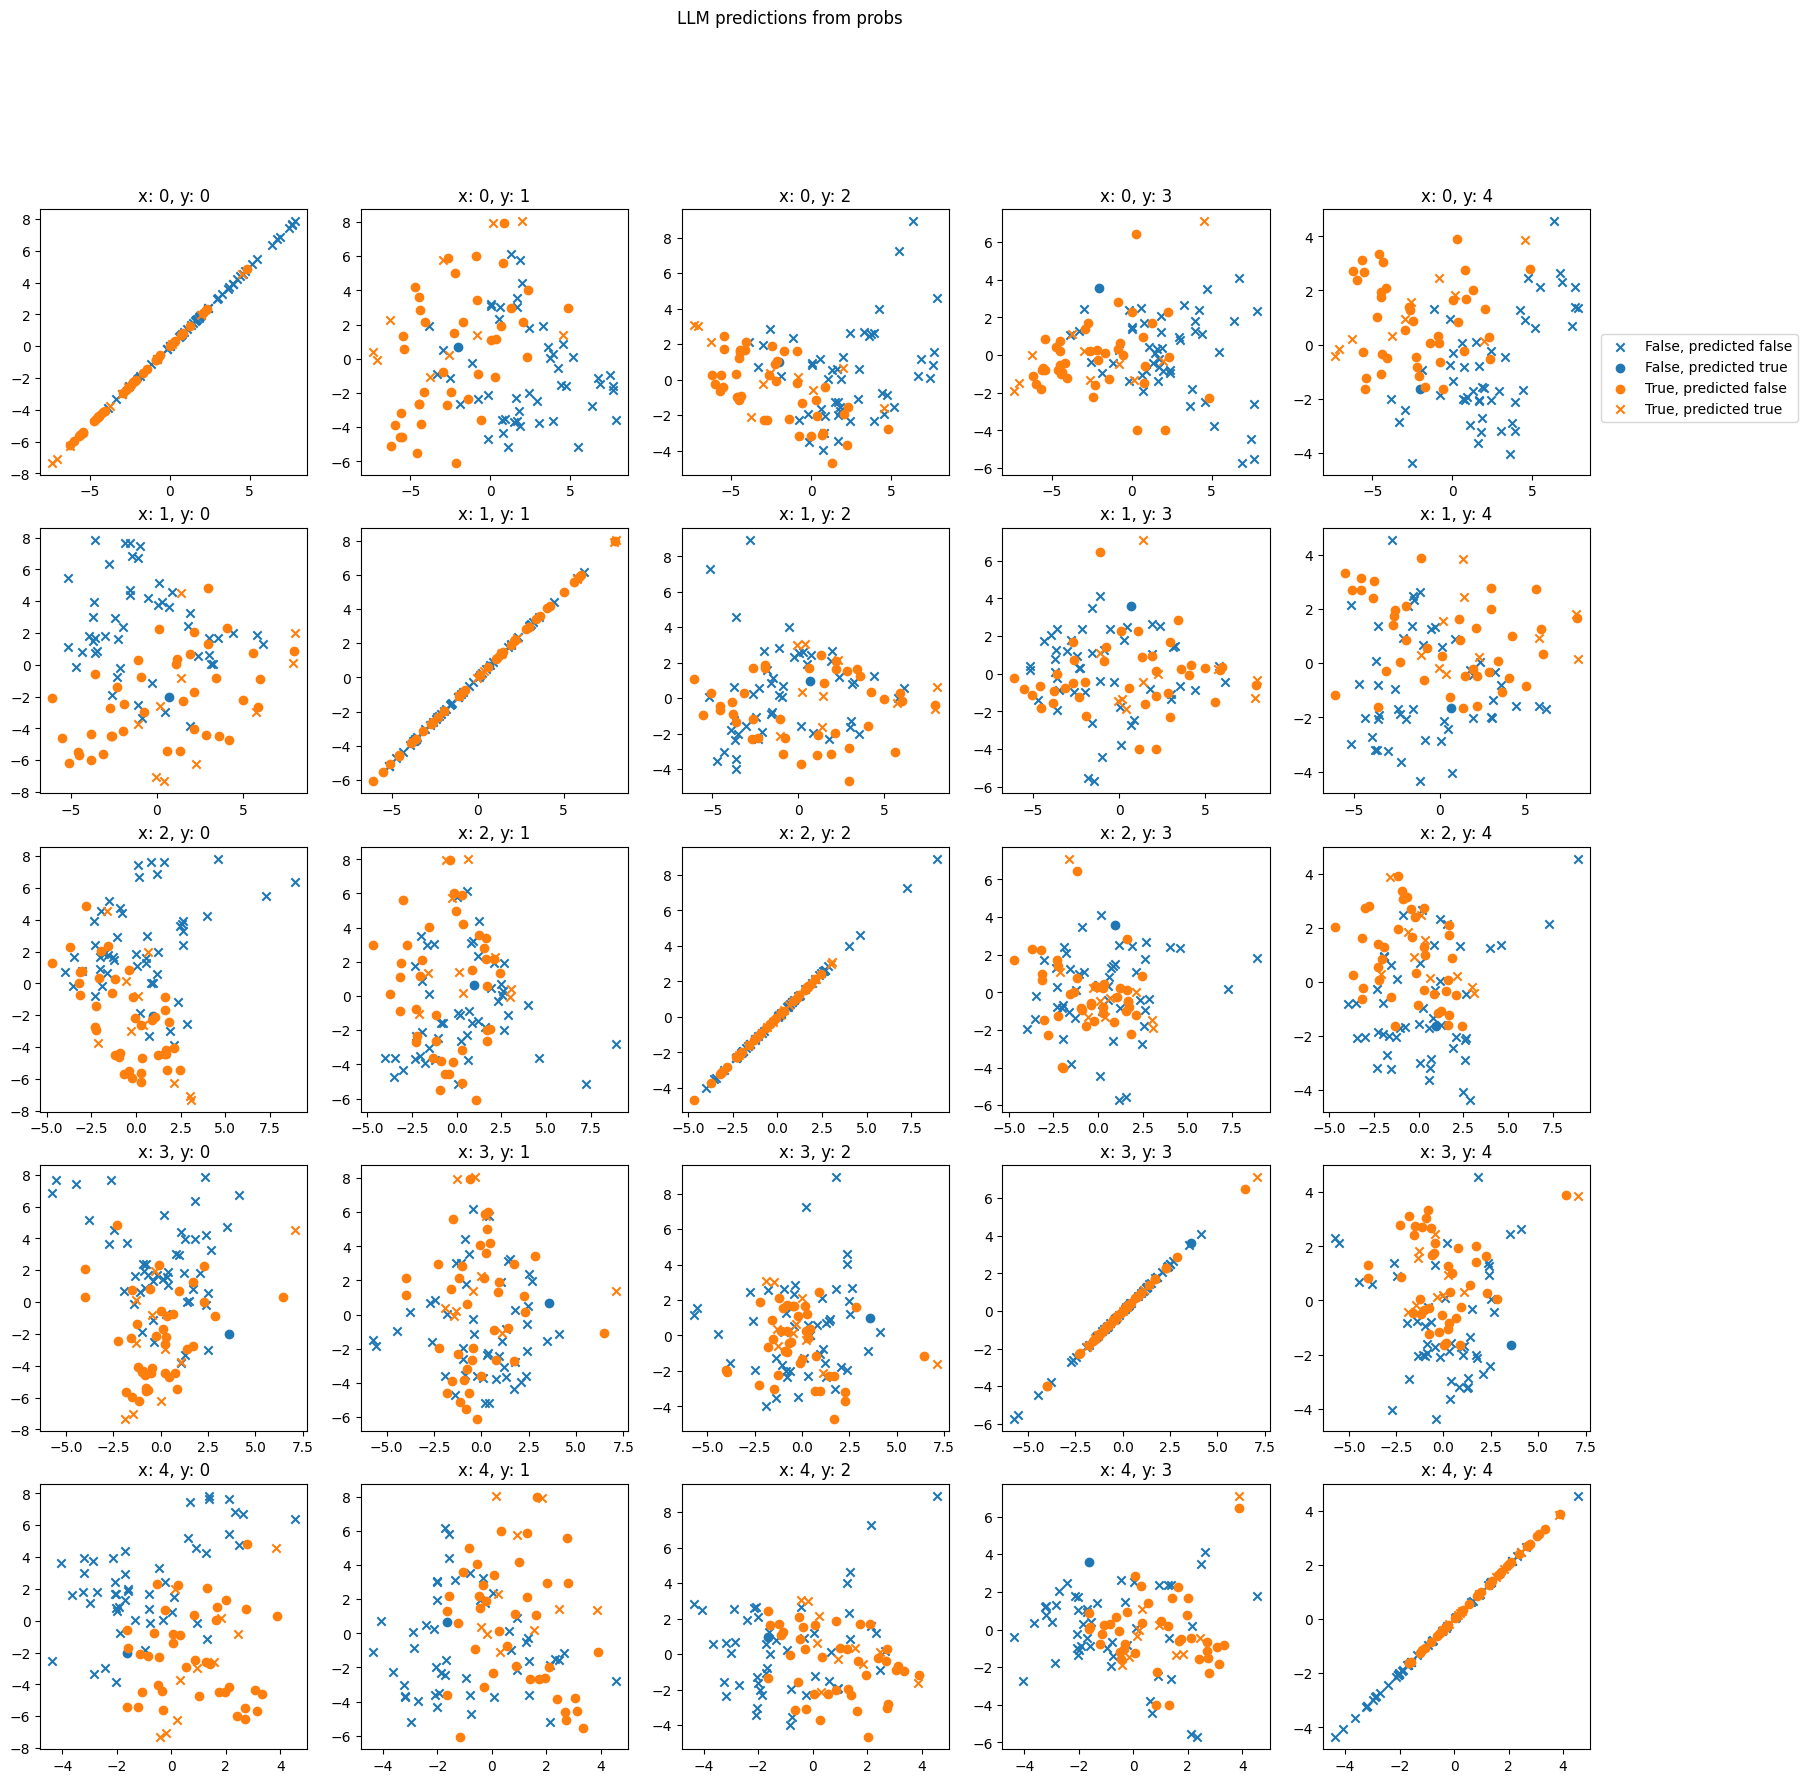

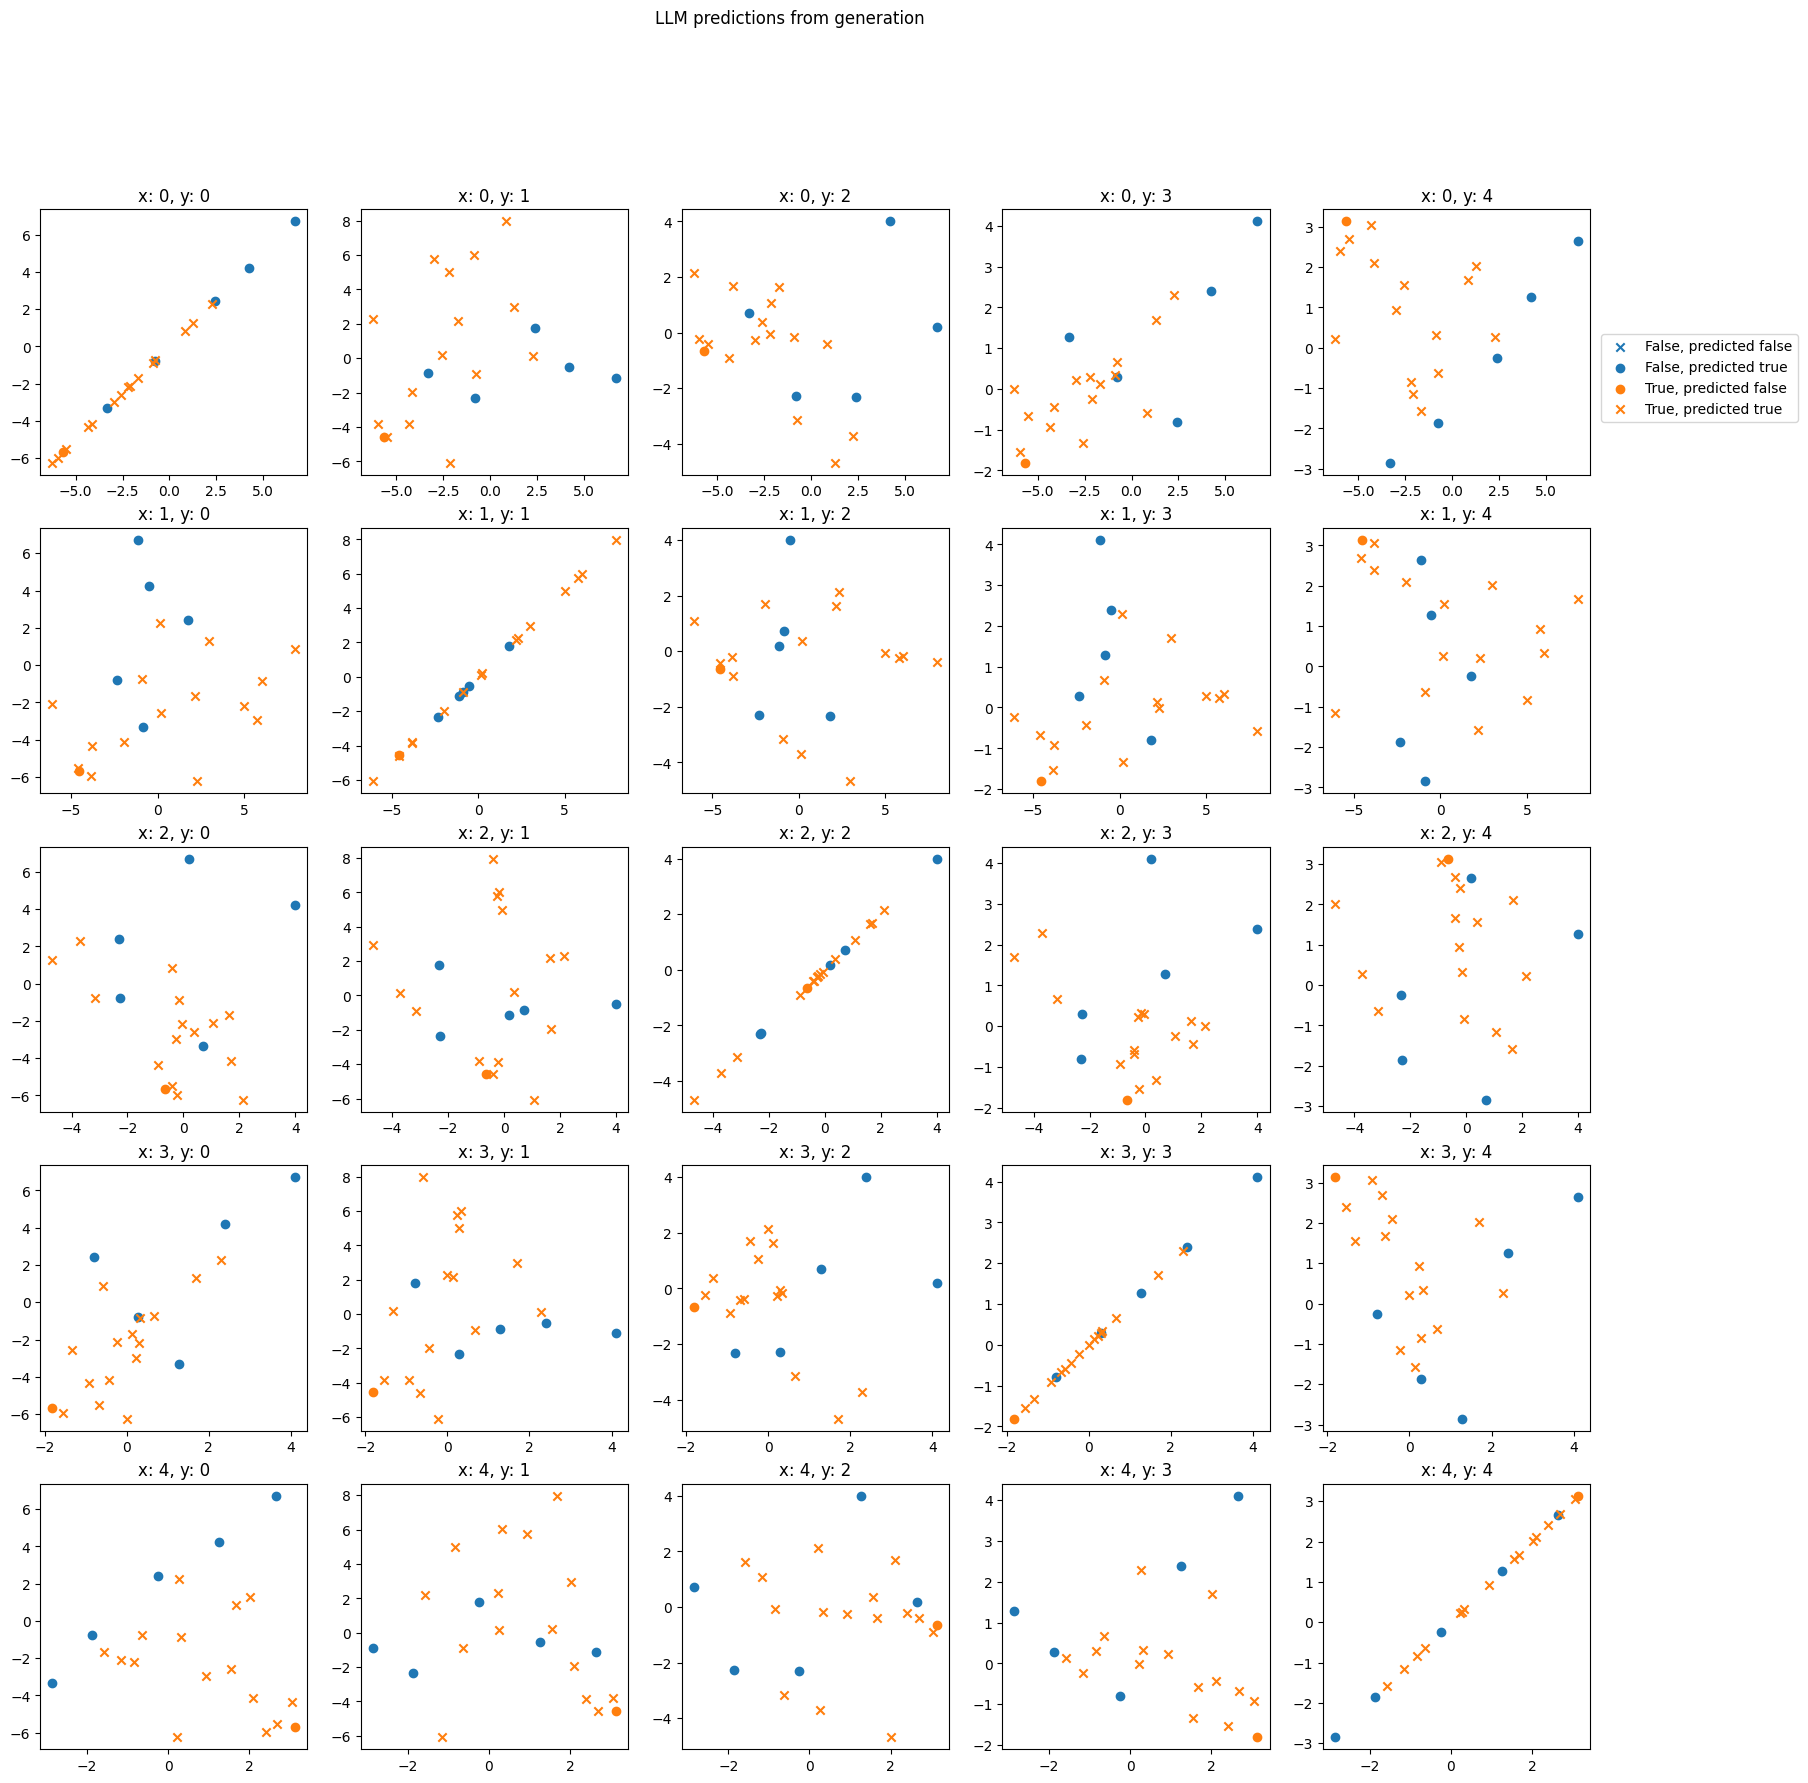

In [9]:
from sklearn.metrics import classification_report

plot_labeled_pca(layer=14, n_components=5, df_concat=df_concat, pred_col="Pred_from_probs", activations=activations)
plt.suptitle("LLM predictions from probs")
plt.show()
plot_labeled_pca(layer=14, n_components=5, df_concat=df_concat, pred_col="Pred_from_gens", activations=activations)
plt.suptitle("LLM predictions from generation")
plt.show()

In [10]:
y_true, y_hat = df_concat['isTrue'].to_numpy(), df_concat['Pred_from_probs'].to_numpy()
print("Classification report when using Yes/No probabilities as LLM truth indicator")
print(classification_report(y_true, y_hat, target_names=["False", "True"]))

y_true, y_hat = df_concat['isTrue'].to_numpy(), df_concat['Pred_from_gens'].to_numpy()
y_true, y_hat = y_true[y_hat!=-1], y_hat[y_hat!=-1]
print("Classification report when using parsing model generation")
print(classification_report(y_true, y_hat, target_names=["False", "True"]))

Classification report when using Yes/No probabilities as LLM truth indicator
              precision    recall  f1-score   support

       False       0.55      0.98      0.71        50
        True       0.91      0.20      0.33        50

    accuracy                           0.59       100
   macro avg       0.73      0.59      0.52       100
weighted avg       0.73      0.59      0.52       100

Classification report when using parsing model generation
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         5
        True       0.75      0.94      0.83        16

    accuracy                           0.71        21
   macro avg       0.38      0.47      0.42        21
weighted avg       0.57      0.71      0.63        21



## Linear probe on the "truthfulness representation" for predicting whether the statement is true

Accuracy 0.78


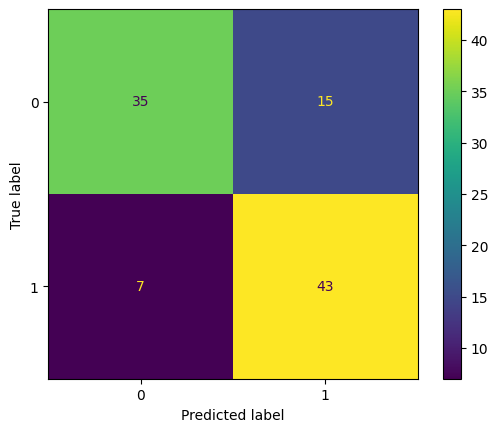

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

layer = 14
X, y = activations[layer,...], df_concat['isTrue'].to_numpy()
accs = []
conf_mat = np.zeros((2,2))
for train_idx, test_idx in KFold(n_splits=5).split(X, y):
    X_train, y_train, X_test, y_test = X[train_idx,...], y[train_idx], X[test_idx,...], y[test_idx]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    accs.append(accuracy_score(y_test, y_pred))
    conf_mat += confusion_matrix(y_test, y_pred)
print(f"Accuracy {np.mean(accs)}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

In [12]:
import torch, gc
model.cpu()
del model
torch.cuda.empty_cache()
gc.collect()

178966

# Llama-2-7b-chat

In [13]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "meta-llama/Llama-2-70b-chat-hf"

model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", load_in_4bit=True, cache_dir=cache_dir)
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)

model.config.pad_token_id = 32000
model.resize_token_embeddings(32001)
model.model.padding_idx = 32000
model.model.embed_tokens.padding_idx = 32000
tokenizer.add_special_tokens({"pad_token": "<pad>"})
new_chat_template = tokenizer.default_chat_template
new_chat_template = new_chat_template.replace("bos_token + ", "")
tokenizer.chat_template = new_chat_template
tokenizer.instruction_template = "[INST]"
tokenizer.response_template = "[/INST]"

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/66.7k [00:00<?, ?B/s]

model-00001-of-00015.safetensors:   0%|          | 0.00/9.85G [00:00<?, ?B/s]

model-00002-of-00015.safetensors:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

model-00003-of-00015.safetensors:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

model-00004-of-00015.safetensors:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

model-00005-of-00015.safetensors:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

model-00006-of-00015.safetensors:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

model-00007-of-00015.safetensors:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

model-00008-of-00015.safetensors:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

model-00009-of-00015.safetensors:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

model-00010-of-00015.safetensors:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

model-00011-of-00015.safetensors:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

model-00012-of-00015.safetensors:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

model-00013-of-00015.safetensors:   0%|          | 0.00/9.80G [00:00<?, ?B/s]

model-00014-of-00015.safetensors:   0%|          | 0.00/9.50G [00:00<?, ?B/s]

model-00015-of-00015.safetensors:   0%|          | 0.00/524M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

## Internal representations of model, marked with model response and ground truth label

In [14]:
activations = compute_activations(df_concat['Statements'], model)   # [layers, statements, np.array([1,tokens,4096])]
make_llm_predictions_with_generation(df_concat, model)
make_llm_predictions_with_probs(df_concat, model);

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

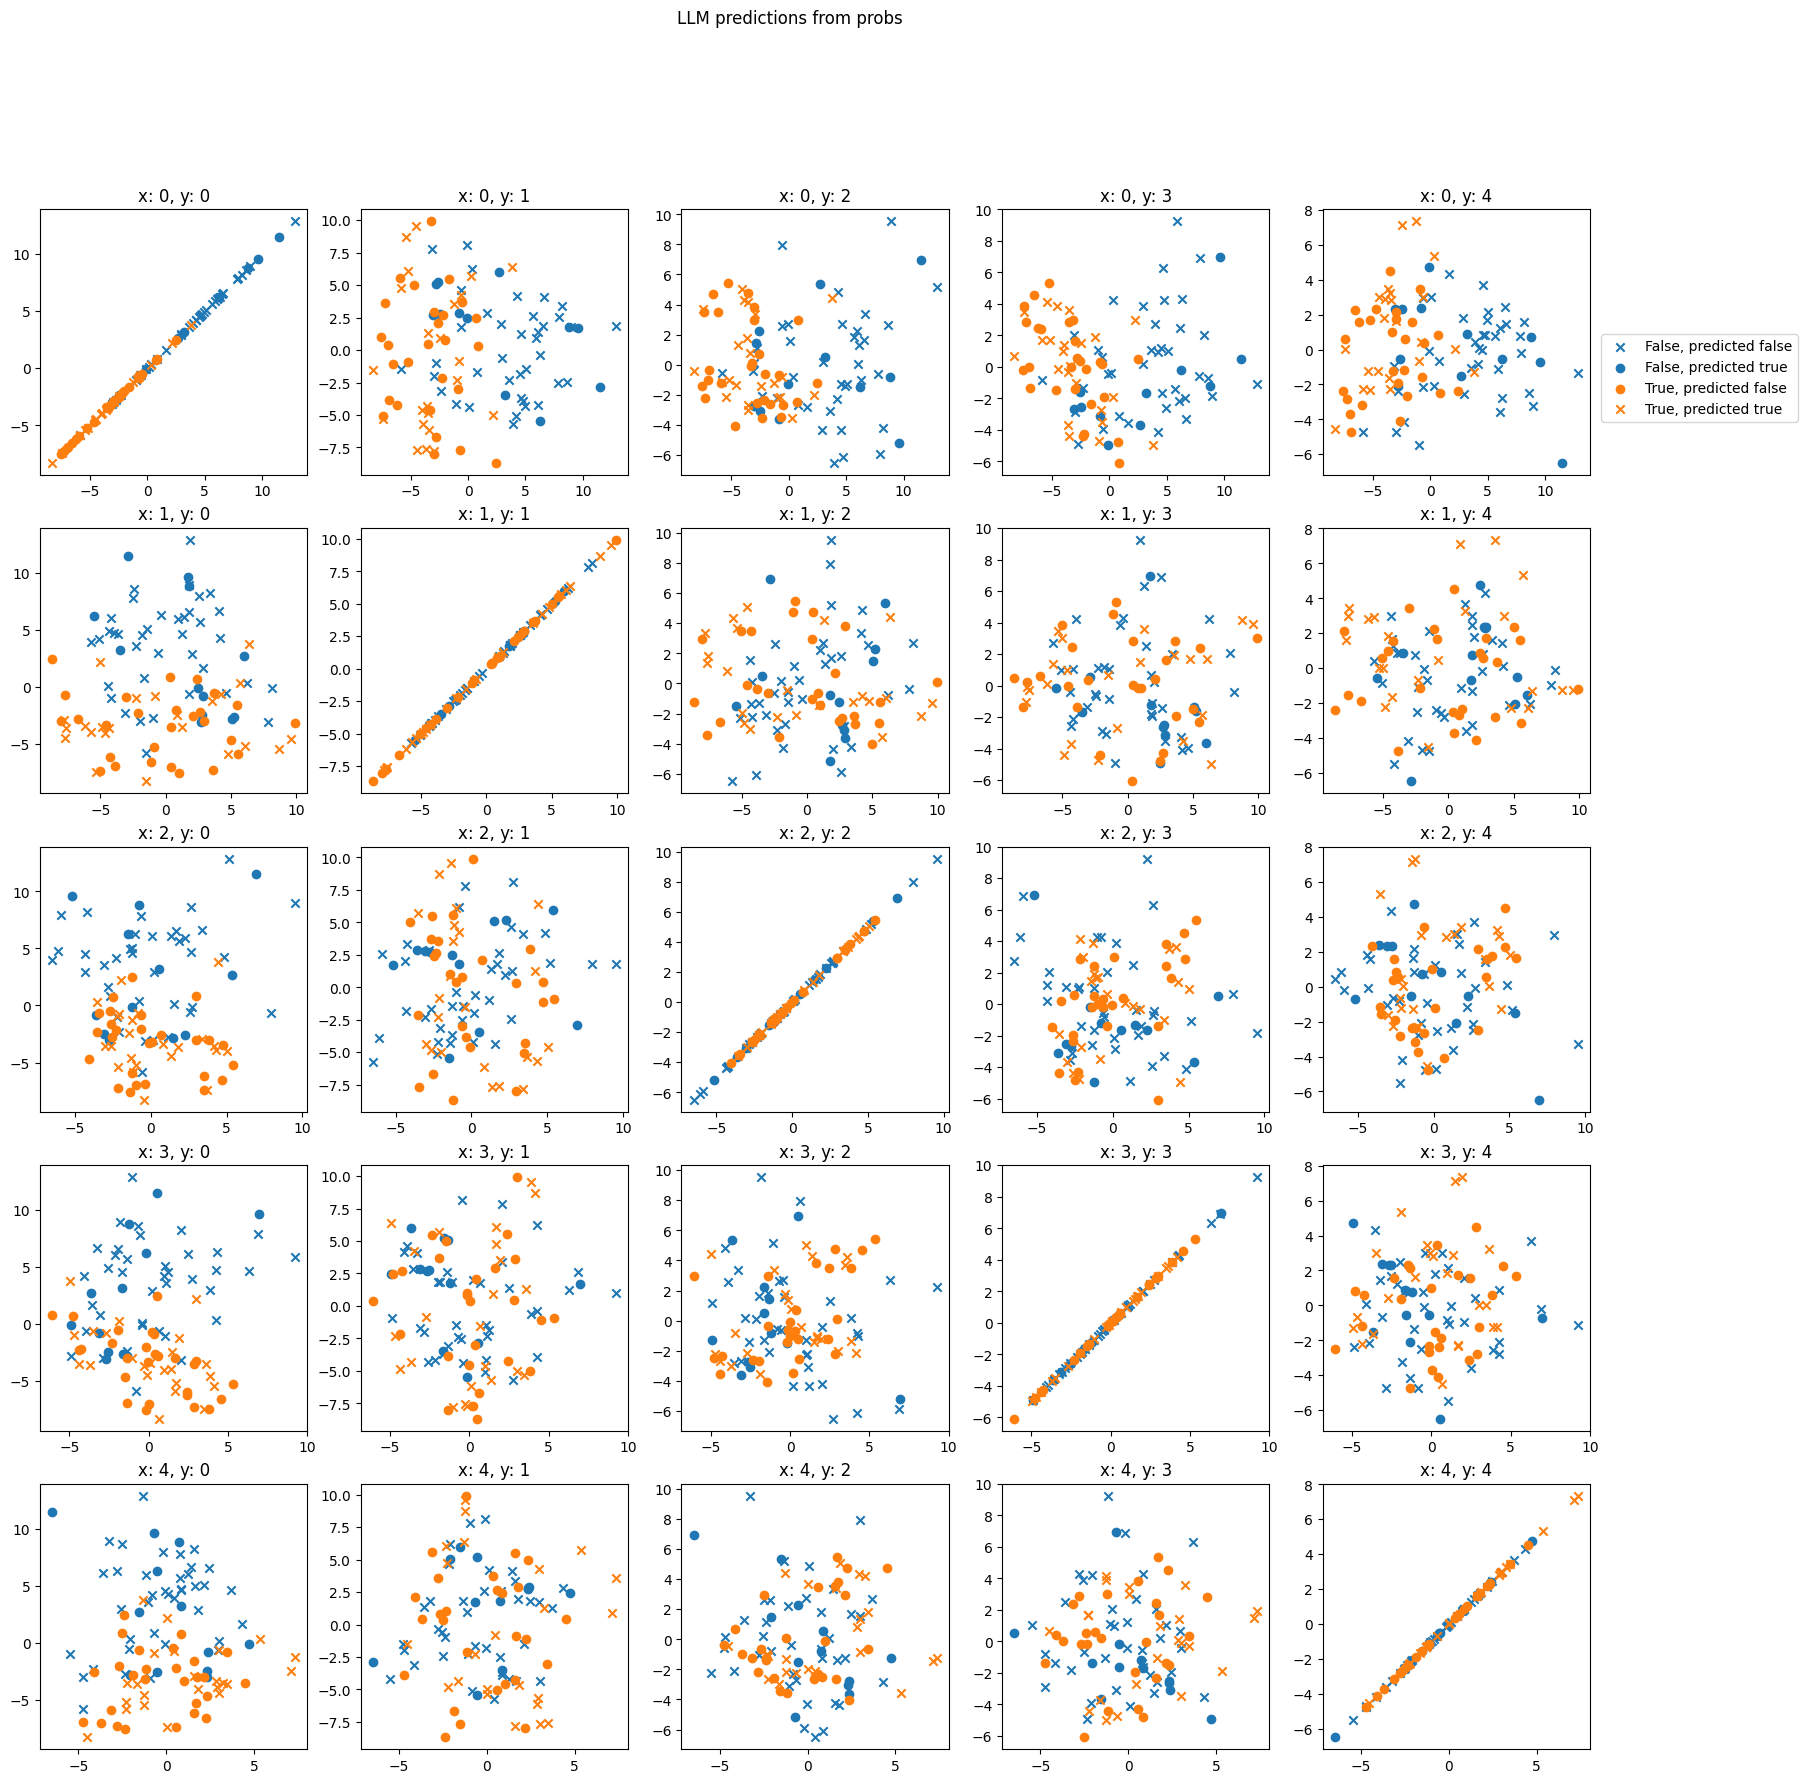

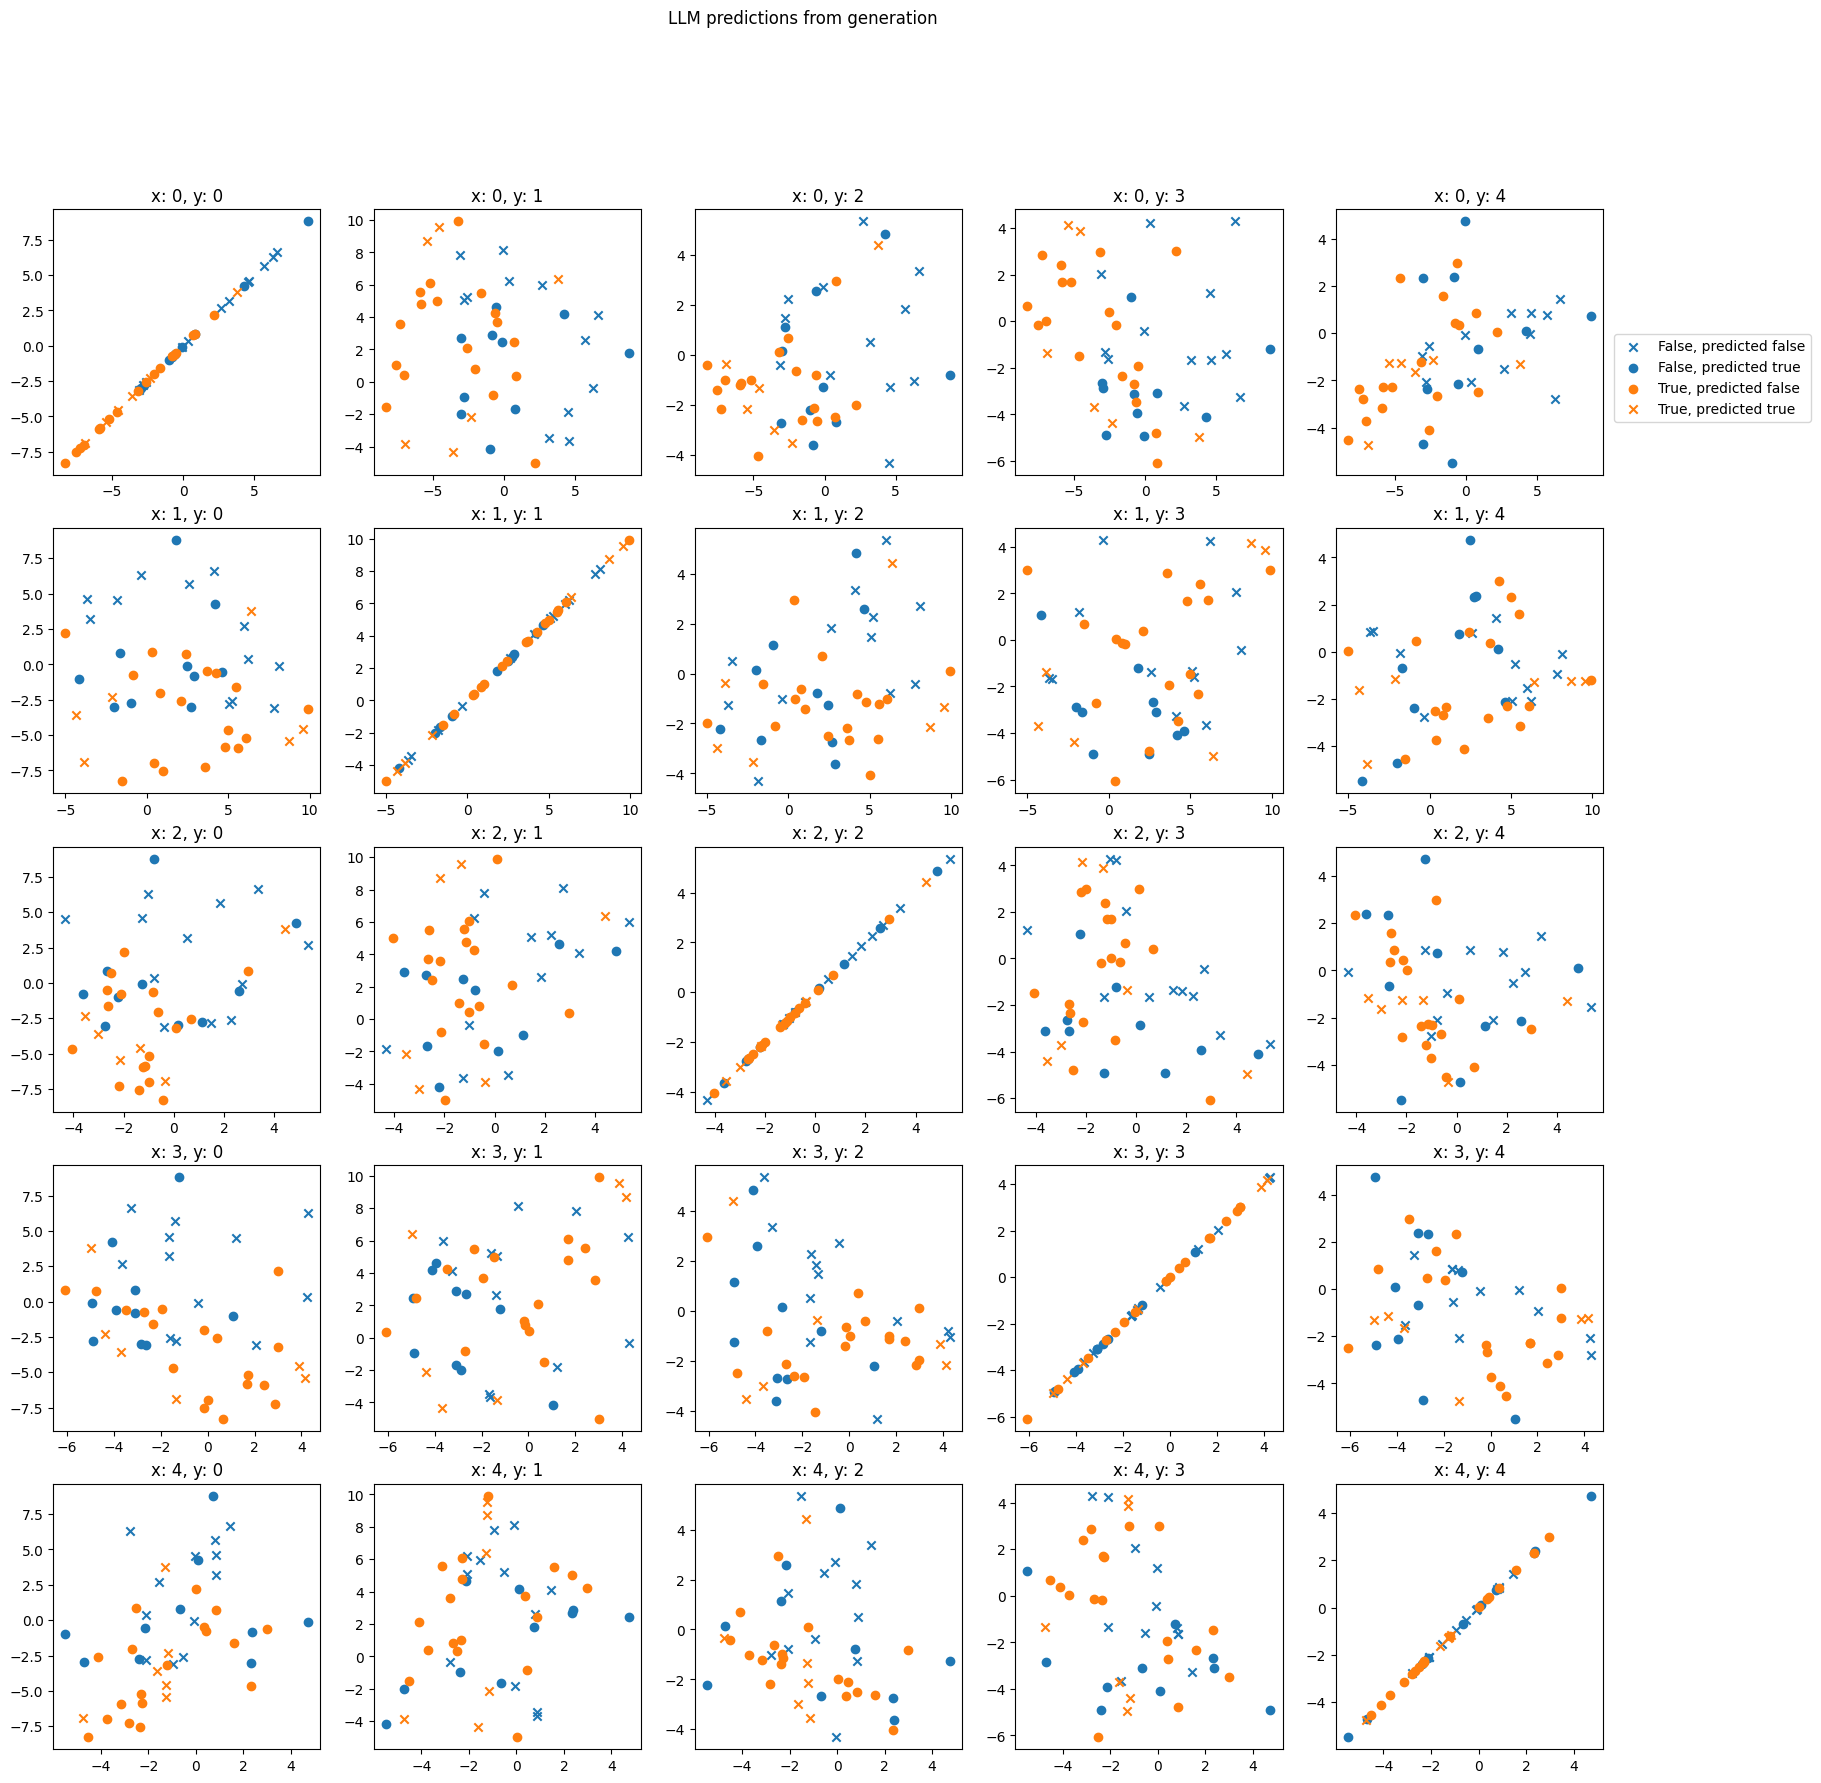

In [15]:
from sklearn.metrics import classification_report

plot_labeled_pca(layer=14, n_components=5, df_concat=df_concat, pred_col="Pred_from_probs", activations=activations)
plt.suptitle("LLM predictions from probs")
plt.show()
plot_labeled_pca(layer=14, n_components=5, df_concat=df_concat, pred_col="Pred_from_gens", activations=activations)
plt.suptitle("LLM predictions from generation")
plt.show()

In [16]:
y_true, y_hat = df_concat['isTrue'].to_numpy(), df_concat['Pred_from_probs'].to_numpy()
print("Classification report when using Yes/No probabilities as LLM truth indicator")
print(classification_report(y_true, y_hat, target_names=["False", "True"]))

y_true, y_hat = df_concat['isTrue'].to_numpy(), df_concat['Pred_from_gens'].to_numpy()
y_true, y_hat = y_true[y_hat!=-1], y_hat[y_hat!=-1]
print("Classification report when using parsing model generation")
print(classification_report(y_true, y_hat, target_names=["False", "True"]))

Classification report when using Yes/No probabilities as LLM truth indicator
              precision    recall  f1-score   support

       False       0.58      0.76      0.66        50
        True       0.66      0.46      0.54        50

    accuracy                           0.61       100
   macro avg       0.62      0.61      0.60       100
weighted avg       0.62      0.61      0.60       100

Classification report when using parsing model generation
              precision    recall  f1-score   support

       False       0.40      0.55      0.46        22
        True       0.38      0.25      0.30        24

    accuracy                           0.39        46
   macro avg       0.39      0.40      0.38        46
weighted avg       0.39      0.39      0.38        46



## Linear probe on the "truthfulness representation" for predicting whether the statement is true

Accuracy 0.76


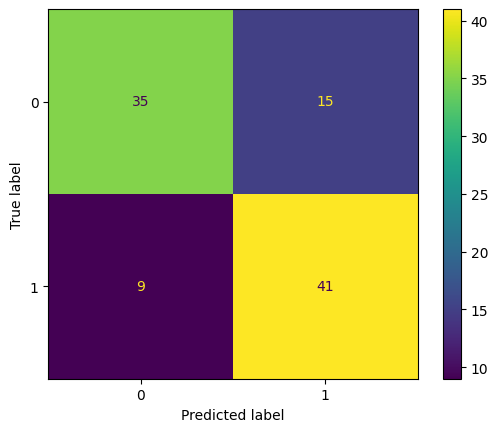

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

layer = 14
X, y = activations[layer,...], df_concat['isTrue'].to_numpy()
accs = []
conf_mat = np.zeros((2,2))
for train_idx, test_idx in KFold(n_splits=5).split(X, y):
    X_train, y_train, X_test, y_test = X[train_idx,...], y[train_idx], X[test_idx,...], y[test_idx]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    accs.append(accuracy_score(y_test, y_pred))
    conf_mat += confusion_matrix(y_test, y_pred)
print(f"Accuracy {np.mean(accs)}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()

In [18]:
df_concat

,Unnamed: 0,name,nameLabel,education,educationLabel,countryLabel,isTrue,Questions,Statements,Responses,Pred_from_gens,Pred_from_probs
3,3,Q76,Barack Obama,Q5130976,Cleary University,United States of America,0,Did Barack Obama attend Cleary University?,Barack Obama attended Cleary University.,Barack Obama did not attend Cleary University...,0,0
4,4,Q76,Barack Obama,Q2001088,Northern State University,United States of America,0,Did Barack Obama attend Northern State Univers...,Barack Obama attended Northern State University.,"No, Barack Obama did not attend Northern Sta...",0,0
5,5,Q76,Barack Obama,Q7895394,University of Florida Athletic Association,United States of America,0,Did Barack Obama attend University of Florida ...,Barack Obama attended University of Florida At...,I couldn't find any information or credible so...,-1,0
6,6,Q76,Barack Obama,Q7896638,University of Wisconsin–Platteville Baraboo Sa...,United States of America,0,Did Barack Obama attend University of Wisconsi...,Barack Obama attended University of Wisconsin–...,Barack Obama did not attend the University of ...,-1,0
7,7,Q76,Barack Obama,Q7082390,Oklahoma State University–Tulsa,United States of America,0,Did Barack Obama attend Oklahoma State Univers...,Barack Obama attended Oklahoma State Universit...,Barack Obama did not attend Oklahoma State Un...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
198,200,Q12927,Marine Le Pen,Q662976,Panthéon-Assas University,France,1,Did Marine Le Pen attend Panthéon-Assas Univer...,Marine Le Pen attended Panthéon-Assas University.,Marine Le Pen did not attend Panthéon-Assas...,0,0
204,206,Q12932,Olivier Besancenot,Q1394262,Paris Nanterre University,France,1,Did Olivier Besancenot attend Paris Nanterre U...,Olivier Besancenot attended Paris Nanterre Uni...,I am not aware of any information about Olivie...,1,1
209,212,Q12961,Nicolas Dupont-Aignan,Q1546437,Paris Dauphine University,France,1,Did Nicolas Dupont-Aignan attend Paris Dauphin...,Nicolas Dupont-Aignan attended Paris Dauphine ...,\nI am not aware of any information about Nico...,1,0
210,213,Q12961,Nicolas Dupont-Aignan,Q859363,Sciences Po,France,1,Did Nicolas Dupont-Aignan attend Sciences Po?,Nicolas Dupont-Aignan attended Sciences Po.,"No, Nicolas Dupont-Aignan did not attend Scien...",0,0


# TODO
- Find a way to truly delete the model from GPU memory.
- Try using a bigger model.